# LightGBM model Bottom-Up
 
We first build features and predict using (reporterhq_id, product_number) as keys and then later aggregate the values.  
Note that this model differs from the other LightGBM where we first aggregate at the product level.

1. **Load and preprocess**
   - Load data
   - Preprocess
   - Features generation

2. **Hyperparameters validation**  
   Performs a TimeSeriesSplit to find the best set of parameters for the LightGBM model.  
   This si done with a RandomizedSearchCV excluding the last 2 batches of 13 weeks.     
   We will use the latter as a test set for the model evaluation.  
   
3. **Model evaluation**  
   Evaluates the model on the last 2 batches of 13 weeks.

4. **Visualisation**  
   Plots some of the time series along with the predicted values.
   - Bottom level predictions
   - Aggregated predictions

## 1. Load and preprocess

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor

import utils.utils as utils
import utils.utils_features as utils_features
import utils.utils_preprocessing as utils_preprocessing
import utils.utils_plots as utils_plots
import utils.constants as constants
from utils.utils_models import LightGBMForecastingModel
from sklearn.model_selection import TimeSeriesSplit

sns.set_theme(style="darkgrid")

In [2]:
df_kaggle = utils_preprocessing.load_and_preprocess(
    file_path=constants.file_path, 
    bottom_up=True, 
    group_col='sku'
    )

/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["first_nonzero_signal"] = df.groupby(coll_agg)["signal_above_zero"].cumsum() > 0
/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["feature_periods"] = df.groupby(coll_agg).cumcount() + 1


## 2. Hyperparameters validation

We will keep the last 2 batches of 13 weeks separate as a test set for the model evaluation.

In [3]:
X_train, X_test, y_train, y_test = utils.train_test_split(df_kaggle, forecasting_horizon=13*2, target_col="y")

In [4]:
cv_split = TimeSeriesSplit(n_splits=10, test_size=13)

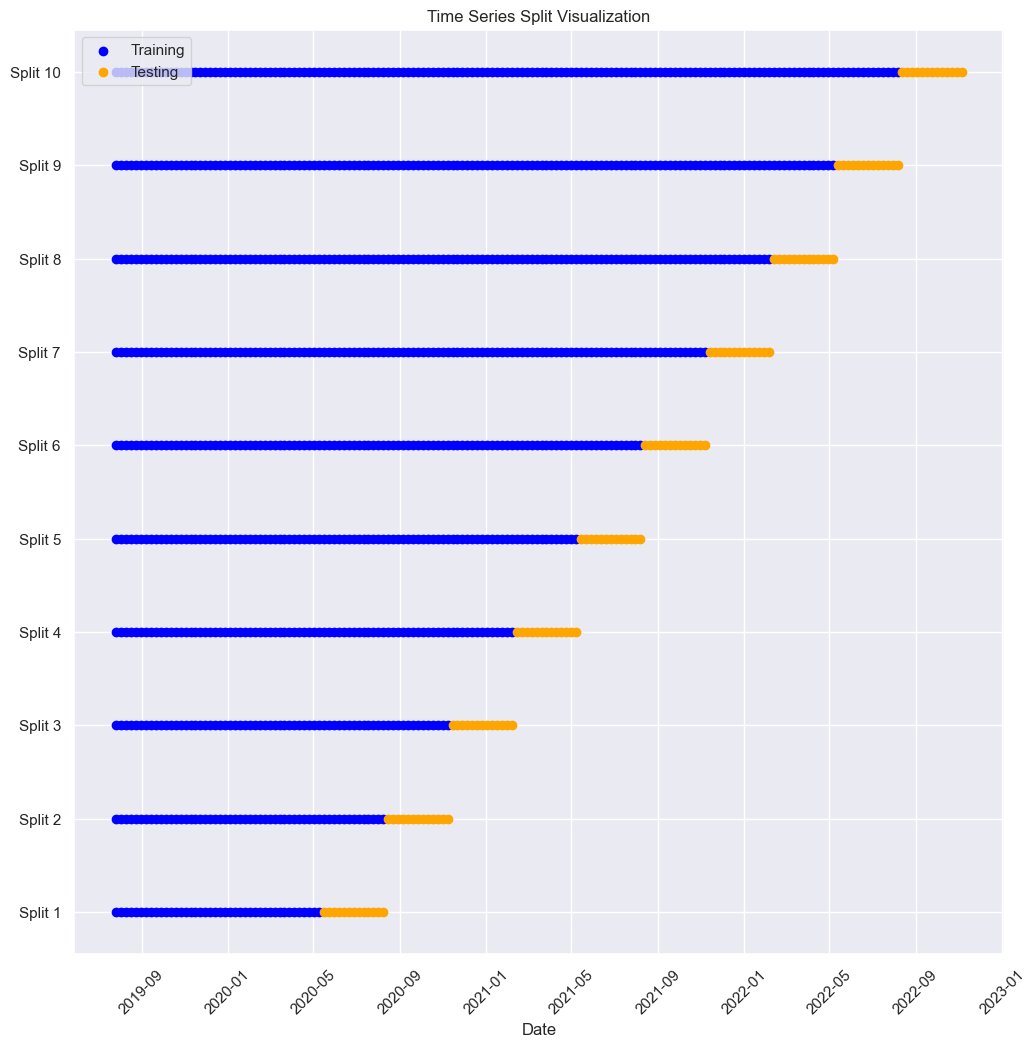

<Figure size 1400x200 with 0 Axes>

In [9]:
utils_plots.plot_time_series_split_with_dates(
    ts_splitter=cv_split, 
    df=X_train)

In [6]:
parameters = {
    'objective': ['regression'],
    "boosting_type": ["gbdt"],
    'metric': ['rmse'],
    'importance_type': ['split'],
    'verbosity': [-1],
    "max_depth": [-1, 1, 3, 4, 5, 6, 10],
    "num_leaves": [10, 20, 30, 40, 100, 120, 150, 200, 250],
    "learning_rate": [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
    "n_estimators": [50, 100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7, 1, 1.2, 1.5],
    "reg_alpha": [0, 0.01, 1, 2, 5, 7, 10, 50, 100],
    "reg_lambda": [0, 0.01, 1, 5, 10, 20, 50, 100]
}


random_search = RandomizedSearchCV(
    estimator=LGBMRegressor(), 
    cv=cv_split, 
    param_distributions=parameters,
    verbose=1
    )
random_search.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=13),
                   estimator=LGBMRegressor(),
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.3, 0.5, 0.7, 1,
                                                             1.2, 1.5],
                                        'importance_type': ['split'],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3,
                                                          0.4, 0.5],
                                        'max_depth': [-1, 1, 3, 4, 5, 6, 10],
                                        'metric': ['rmse'],
                                        'n_estimators': [50, 100, 300, 500, 700,
                                                         900, 1000],
                                        'num_leaves': [10, 20, 30, 40, 100, 120,
                                                       150, 200, 250],
                                        'objective': ['regression'],
                                        'reg_alpha': [0, 0.01, 1, 2, 5, 7, 10,
                                                      50, 100],
                                        'reg_lambda': [0, 0.01, 1, 5, 10, 20,
                                                       50, 100],
                                        'verbosity': [-1]},
                   verbose=1)

In [7]:
best_model = random_search.best_estimator_
optimal_params = best_model.get_params()

In [8]:
optimal_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.5,
 'importance_type': 'split',
 'learning_rate': 0.3,
 'max_depth': 5,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'num_leaves': 20,
 'objective': 'regression',
 'random_state': None,
 'reg_alpha': 7,
 'reg_lambda': 5,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbosity': -1,
 'metric': 'rmse'}

In [14]:
optimal_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.7,
 'importance_type': 'split',
 'learning_rate': 0.2,
 'max_depth': 4,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'num_leaves': 20,
 'objective': 'regression',
 'random_state': None,
 'reg_alpha': 10,
 'reg_lambda': 20,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'rmse'}

In [5]:
optimal_params = {
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'importance_type': 'split',
    'learning_rate': 0.03,
    'max_depth': 10,
    'min_child_samples': 25,
    'min_child_weight': 0.034,
    'min_split_gain': 0.0,
    'n_estimators': 50,
    'n_jobs': None,
    'num_leaves': 157,
    'objective': 'regression',
    'random_state': 222,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'subsample': 0.6,
    'subsample_for_bin': 200000,
    'subsample_freq': 0,
    'bagging_fraction': 0.418,
    'bagging_seed': 11,
    'feature_fraction': 0.379,
    'metric': 'rmse',
    'min_data_in_leaf': 106,
    'verbosity': -1,
    }

## 3. Model evaluation

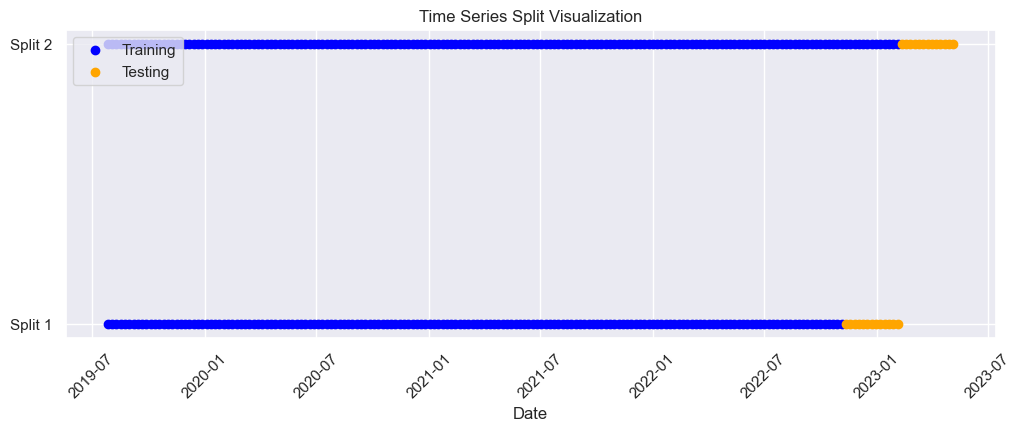

<Figure size 1400x200 with 0 Axes>

In [6]:
tss = TimeSeriesSplit(2, test_size=13)
utils_plots.plot_time_series_split_with_dates(
    ts_splitter=tss, 
    df=df_kaggle)

In [7]:
fc_model = LightGBMForecastingModel(hyperparameters=optimal_params, bottom_up=True)
results_cv = fc_model.cross_validate(df_kaggle, n_splits=2)

Train [2019-07-27 - 2022-11-05]
Predict [2022-11-12 - 2023-02-04]
Train [2019-07-27 - 2023-02-04]
Predict [2023-02-11 - 2023-05-06]
Average RMSE from cross-validation: 50.9340

Average RMSE after aggregating per id: 71.2030


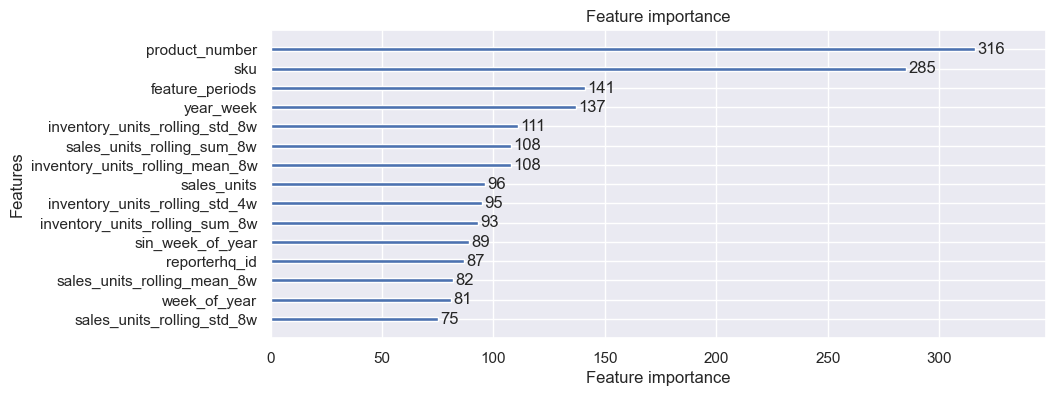

In [8]:
fc_model.plot_feature_importance()

In [9]:
fc_model.train(X_train, y_train)
fc_model.save_model("./models/lightgbm_bottom_up.pk")

## 4. Visualisation
### Bottom level predictions

In [10]:
df_preds = utils.predict_last_13_weeks(df_kaggle, fc_model)
df_final = df_kaggle.merge(df_preds.reset_index(), on=['date', 'sku'], how='left')

In [11]:
num_select = 4
#list_skus = np.random.choice(df_preds['sku'].unique(), size=num_select, replace=False) # Random
list_skus = df_preds["sku"].cat.remove_unused_categories().value_counts().index[:num_select].values # More entries in the dataset
#list_skus = df_preds["sku"].cat.remove_unused_categories().value_counts().index[-num_select:].values # Less entries in the dataset

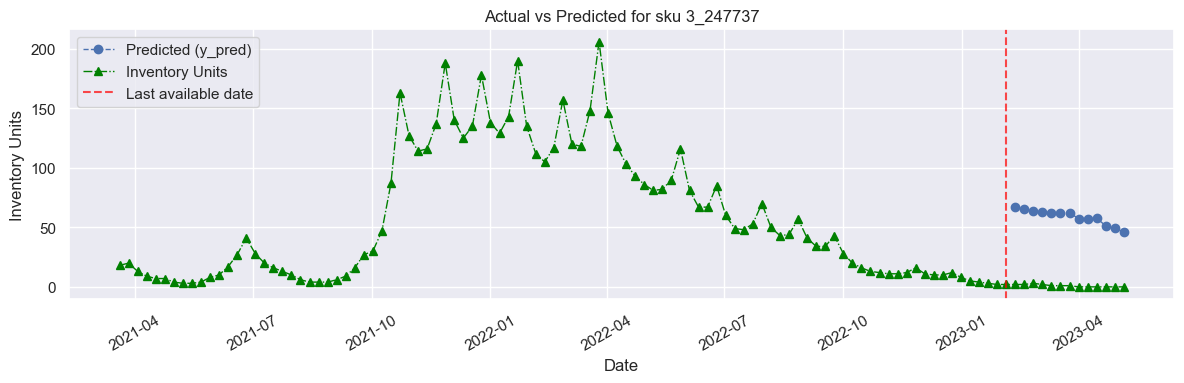

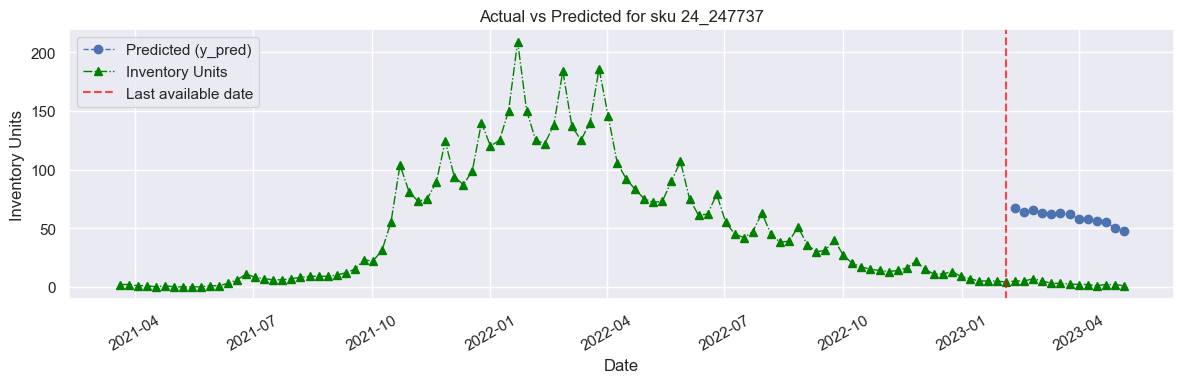

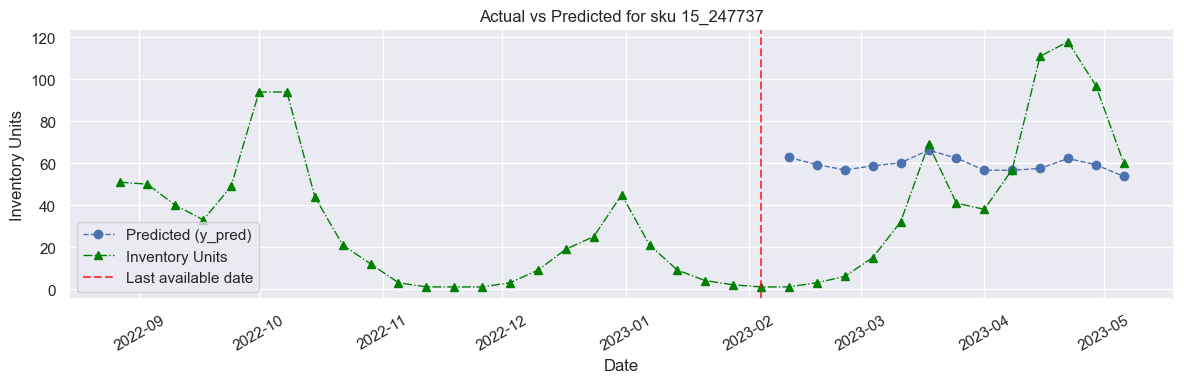

In [12]:
date_present = df_final['date'].max() - pd.DateOffset(weeks=13)
for sku in ['3_247737', '24_247737', '15_247737']:#list_skus:
    utils_plots.plot_real_vs_predicted(df_final, sku, pred_columns=['y_pred'], col_agg='sku', vline_dates=[date_present])

### Aggregated predictions

In [12]:
df_aggregated = utils.aggregate_predictions(df_final)

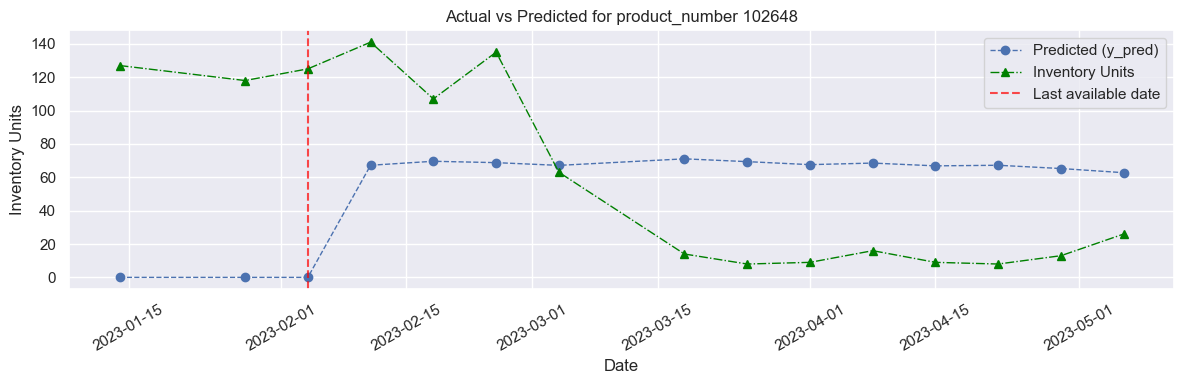

In [13]:
utils_plots.plot_real_vs_predicted(df_aggregated, single_ts=102648, pred_columns=['y_pred'], col_agg='product_number', vline_dates=[date_present])

In [14]:
df_final[df_final['product_number']==247737]['sku'].unique()

['24_247737', '3_247737', '15_247737']
Categories (506, object): ['12_10857', '12_110544', '12_112518', '12_11844', ..., '9_42441', '9_68103', '9_70077', '9_74025']

In [15]:
df_final[df_final.duplicated(['date', 'id'])]['product_number'].unique()

[233919, 247737, 24675, 32571, 8883, ..., 23688, 118440, 168777, 232932, 209244]
Length: 153
Categories (233, int64): [2961, 3948, 4935, 5922, ..., 245763, 246750, 247737, 248724]